In [104]:
from scipy.spatial.distance import pdist
import io
import numpy as np
import math
from math import exp
import numpy.linalg as linalg
from sklearn import metrics
from sklearn.cross_validation import KFold
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_mldata
from cvxopt import solvers,matrix 
from cvxopt.base import matrix as m
from pylab import *
from scipy.spatial.distance import cdist
%matplotlib inline

In [18]:
filename = "breast-cancer-wisconsin.data.txt"
r = io.open(filename, encoding='utf8').readlines()
X = []
Y = []
for i in r:
    x = i.split(',')
    for j in range(1,len(x)-1):
        try:
            x[j] = float(x[j])
        except ValueError:
            x[j] = 0
    X.append(map(float,x[1:len(x)-1]))
    if int(x[-1]) == 2:
        Y.append([-1.0])
    elif int(x[-1]) == 4:
        Y.append([1.0])
Y = np.array(Y)
X = np.array(X)

In [19]:
def find_alpha1(class_labels):
    alpha1 = {}
    class_count1 = {}
    for i in class_labels:
        if i[0] not in class_count1.keys():
            class_count1[i[0]] = 1
        else:
            class_count1[i[0]] += 1
    classes1 = class_count1.keys()
    for j in  class_count1:
        alpha1[j] = class_count1[j]*1.0/len(class_labels)
    return classes1,class_count1,alpha1

In [60]:
def classify_dataset(w,w0,x):
    y = []
    for i in x:
        if (w0 + np.dot(w,i)) > 0:
            y.append([1.0])
        elif (w0 + np.dot(w,i)) < 0:
            y.append([-1.0])
    return y

In [21]:
def segregate_data(data,labels,clabels):
    multi_X = {}
    for i in range(len(clabels)):
        if clabels[i] not in multi_X.keys():
            multi_X[clabels[i]] = []
        for j in range(len(labels)):
            if labels[j][0] == clabels[i]:
                multi_X[clabels[i]].append(data[j]) 
    for i in multi_X:
        multi_X[i] = np.array(multi_X[i])
    return multi_X

In [256]:
def lin_sep_data(s,f,d,w,w0):
    n = s/2
    xx = np.append((np.random.randn(n,f)+d),(np.random.randn(n,f)-d),axis =0)
    yy = classify_dataset(w,w0,xx)
    return xx,np.array(yy)

In [255]:
def lin_nonsep_data(s,f,d,w,w0):
    n = s/2
    xx = np.append((np.random.randn(n,f)+d),(np.random.randn(n,f)-d),axis =0)
    yy = classify_dataset(w,w0,xx)
    return xx,np.array(yy)

In [189]:
def matP(x,y,c,gram,typ):
    p = np.dot(y,y.T) * gram
    p = m(p)
    q = m([-1.0] * x.shape[0])
    g1 = np.zeros((x.shape[0], x.shape[0]), float)
    g2 = np.zeros((x.shape[0], x.shape[0]), float)
    np.fill_diagonal(g1, -1.0)
    np.fill_diagonal(g2, 1.0)
    if typ == 'hard':
        h = m([0.0] * x.shape[0] )
        g = m(g1)
    elif typ == 'soft':
        h = m(([0.0] * x.shape[0] + [c] * x.shape[0]))
        g = m(np.append(g1,g2,axis=0))
    try:
        a = m(y.T)
    except TypeError:
        a = m(np.ndarray.tolist(y))
    return p,q,h,g,a

In [190]:
def find_alpha(p,q,g,h,a,b):
    dual = solvers.qp(p,q,g,h,a,b)
    alphas = np.matrix(dual['x'])
    return alphas

In [191]:
def find_sv(alphas, data, ep, c, typ):
    sv = []
    if typ == 'hard':
        for i in range(len(alphas)):
            if alphas[i] > ep:
                sv.append(data[i])
    elif typ == 'soft':
        for i in range(len(alphas)):
            if alphas[i] > ep and alphas[i] < c :
                sv.append(data[i])
    return np.matrix(sv)

In [192]:
def find_parm(alphas,data,y,ep,c,typ):
    svm = find_sv(alphas,data,ep,c,typ)
    w = 0
    for i in range(len(alphas)):
        w = w + (alphas[i] * y[i] * data[i])
    w0 = 0
    for j in range((len(y))):
        w0 = w0 + (y[i] - np.dot(w,data[i]))
    w0 = w0 / len(svm)
    return w,w0,svm

In [204]:
def normal_gram(data):
    return np.dot(data,data.T)

In [209]:
def plotdata(svm,xx,yy):
    svm = np.array(svm)
    classes,count,pr = find_alpha1(yy)
    xrs = segregate_data(xx,yy,classes)
    x_neg = []
    y_neg = []
    x_pos = []
    y_pos = []
    x_svm = []
    y_svm = []
    for i in xrs:
        if i == -1:
             for j in xrs[i]:
                x_neg.append(j[0])
                y_neg.append(j[1])
        if i == 1:
            for j in xrs[i]:
                x_pos.append(j[0])
                y_pos.append(j[1])
    for k in svm:
        x_svm.append(k[0])
        y_svm.append(k[1])
    plt.plot(x_neg,y_neg,'ro')
    plt.plot(x_pos,y_pos,'bo')
    plt.plot(x_svm,y_svm,'gx')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [330]:
def plotdata1(svm,xx,yy):
    svm = np.array(svm)
    classes,count,pr = find_alpha1(yy)
    xrs = segregate_data(xx,yy,classes)
    x_neg = []
    y_neg = []
    x_pos = []
    y_pos = []
    x_svm = []
    y_svm = []
    for i in xrs:
        if i == -1:
             for j in xrs[i]:
                x_neg.append(j[0])
                y_neg.append(j[1])
        if i == 1:
            for j in xrs[i]:
                x_pos.append(j[0])
                y_pos.append(j[1])
    for k in svm:
        x_svm.append(k[0])
        y_svm.append(k[1])
    plt.plot(x_neg,y_neg,'ro')
    plt.plot(x_pos,y_pos,'bo')
    plt.plot(x_svm,y_svm,'gs')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [193]:
def training(data,y,gram,ep = 0,c=1,typ = 'hard'):
    P1,Q1,H1,G1,A1 = matP(data,y,c,gram,typ)
    b1 = m(1.0)
    alpha1 = find_alpha(P1,Q1,G1,H1,A1,b1)
    W1,W10,SVM = find_parm(alpha1,data,y,ep,c,typ)
    return W1,W10,SVM 

In [194]:
def prediction(w,w0,data):
    pred = []
    for i in data:
        prod = np.dot(w,i) + w0
        if prod > 0:
            pred.append([1])
        else:
            pred.append([-1])
    return np.array(pred)        

In [195]:
def find_confusion_matrix(clabels,actual,predicted):
    cm= []
    for i in clabels:
        tmp =[0]*len(clabels)
        for j in range(len(actual)):
            if actual[j][0] == i and actual[j][0] == predicted[j][0]:
                tmp[clabels.index(i)] += 1
            elif actual[j][0] == i and actual[j][0] != predicted[j][0]:
                tmp[clabels.index(predicted[j][0])] += 1
        cm.append(tmp)
    return np.array(cm)
def find_accuracy(matrix):
    return np.trace(matrix)*1.0/np.sum(matrix)
def find_precision(matrix):
    pres = []
    x = np.sum(matrix,axis=0)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                pres.append(matrix[i][j]*1.0/x[i])
    return pres
def find_recall(matrix):
    rec = []
    x = np.sum(matrix,axis=1)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                rec.append(matrix[i][j]*1.0/x[i])
    return rec
def find_fmeasure(prec,rec):
    tmp = []
    for i,j in zip(prec,rec):
        tmp.append(2.0*(i*j)/(i+j))
    return tmp

In [196]:
def evaluation(clabels,acutal,predicted):
    confmatrix = find_confusion_matrix(clabels,acutal,predicted)
    print "Confusion Matrix"
    print confmatrix
    accuracy = find_accuracy(confmatrix)
    print "Accuracy", accuracy
    precision = find_precision(confmatrix)
    print "Precision", precision
    recall = find_recall(confmatrix)
    print "Recall", recall
    f_score =find_fmeasure(precision,recall)
    print "F_score", f_score

In [205]:
def kernel_gram_matrix(x,sigma):
    d = cdist(x,x,'sqeuclidean')    
    return np.exp((-1/2)*(d/sigma**2))

In [137]:
def poly_kernel(data,q):
    x_poly = []
    for i in data:
        tmp = []
        for j in data:
            tmp.append((np.dot(i,j)+1)**1)
        x_poly.append(tmp)
    return np.array(x_poly)

In [220]:
ww = np.array([[0.5,0.5 ]])
ww0 = np.array([[0]])
X_lin,Y_lin = lin_sep_data(100,2,2,ww,ww0)

## Hard margin linearly separable

     pcost       dcost       gap    pres   dres
 0: -1.2325e+01 -2.0943e+01  3e+02  2e+01  2e+00
 1: -1.1206e+01 -3.2563e+00  4e+01  3e+00  3e-01
 2: -7.3358e-01 -4.4958e-01  2e+00  1e-01  1e-02
 3: -3.4858e-01 -3.0963e-01  7e-01  4e-02  3e-03
 4: -2.7193e-01 -2.4835e-01  2e-01  1e-02  9e-04
 5: -2.3546e-01 -2.3243e-01  1e-02  6e-04  6e-05
 6: -2.3204e-01 -2.3201e-01  1e-04  6e-06  6e-07
 7: -2.3201e-01 -2.3201e-01  1e-06  6e-08  6e-09
 8: -2.3201e-01 -2.3201e-01  1e-08  6e-10  6e-11
Optimal solution found.


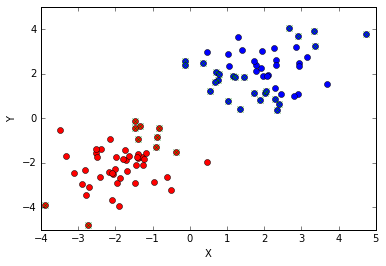

Confusion Matrix
[[50  0]
 [ 0 50]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [221]:
G = normal_gram(X_lin)
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'hard')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_hard = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_hard)

### Soft Margin Linearly Separable

     pcost       dcost       gap    pres   dres
 0: -1.2276e+01 -1.9867e+02  1e+03  3e+00  8e-15
 1: -6.2896e+00 -1.0539e+02  2e+02  3e-01  8e-15
 2: -1.1038e+00 -1.4824e+01  2e+01  4e-02  9e-15
 3: -2.3813e-02 -2.9941e+00  4e+00  6e-03  4e-15
 4: -1.0541e-01 -8.3517e-01  1e+00  1e-03  2e-15
 5: -1.8809e-01 -3.0952e-01  1e-01  7e-05  1e-15
 6: -2.3113e-01 -2.3299e-01  2e-03  8e-07  1e-15
 7: -2.3200e-01 -2.3202e-01  2e-05  8e-09  1e-15
 8: -2.3201e-01 -2.3201e-01  2e-07  8e-11  2e-15
Optimal solution found.


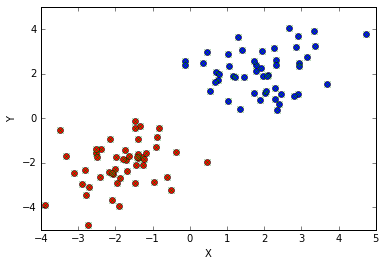

Confusion Matrix
[[50  0]
 [ 0 50]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [222]:
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'soft')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_soft = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_soft)

# Gaussian Kernel

### Hard Margin Lineraly Separable

     pcost       dcost       gap    pres   dres
 0: -3.4927e+01 -8.3680e+01  5e+01  7e-15  2e+00
 1: -4.3131e+01 -4.4612e+01  1e+00  2e-14  3e-01
 2: -4.5604e+01 -4.5805e+01  2e-01  1e-14  1e-02
 3: -4.5619e+01 -4.5624e+01  5e-03  1e-15  2e-04
 4: -4.5621e+01 -4.5621e+01  9e-05  2e-14  2e-06
 5: -4.5621e+01 -4.5621e+01  9e-07  1e-14  2e-08
Optimal solution found.


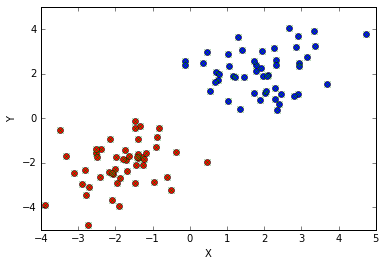

Confusion Matrix
[[48  2]
 [ 0 50]]
Accuracy 0.98
Precision [1.0, 0.96153846153846156]
Recall [0.95999999999999996, 1.0]
F_score [0.97959183673469385, 0.98039215686274506]


In [223]:
G = kernel_gram_matrix(X_lin,0.1)
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'hard')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_soft = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_soft)

### Soft Margin Lineraly Separable - Gaussian

     pcost       dcost       gap    pres   dres
 0: -4.1231e+01 -1.5438e+02  1e+02  9e-15  4e-16
 1: -4.3195e+01 -5.0471e+01  7e+00  1e-14  2e-16
 2: -4.5191e+01 -4.6492e+01  1e+00  2e-14  1e-16
 3: -4.5558e+01 -4.5728e+01  2e-01  2e-14  9e-17
 4: -4.5611e+01 -4.5631e+01  2e-02  2e-14  9e-17
 5: -4.5618e+01 -4.5620e+01  2e-03  4e-15  1e-16
 6: -4.5619e+01 -4.5619e+01  6e-05  2e-15  1e-16
 7: -4.5619e+01 -4.5619e+01  1e-06  1e-14  9e-17
Optimal solution found.


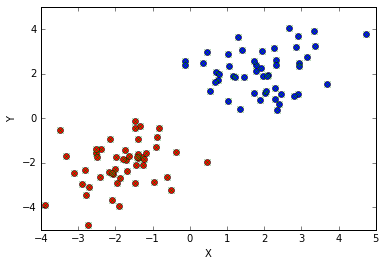

Confusion Matrix
[[48  2]
 [ 0 50]]
Accuracy 0.98
Precision [1.0, 0.96153846153846156]
Recall [0.95999999999999996, 1.0]
F_score [0.97959183673469385, 0.98039215686274506]


In [224]:
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'soft')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_soft = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_soft)

## Polynomial Kernel

     pcost       dcost       gap    pres   dres
 0: -1.1825e+01 -2.0443e+01  3e+02  2e+01  2e+00
 1: -1.0706e+01 -2.7563e+00  4e+01  3e+00  3e-01
 2: -2.3358e-01  5.0422e-02  2e+00  1e-01  1e-02
 3:  1.5142e-01  1.9037e-01  7e-01  4e-02  3e-03
 4:  2.2807e-01  2.5165e-01  2e-01  1e-02  9e-04
 5:  2.6454e-01  2.6757e-01  1e-02  6e-04  6e-05
 6:  2.6796e-01  2.6799e-01  1e-04  6e-06  6e-07
 7:  2.6799e-01  2.6799e-01  1e-06  6e-08  6e-09
 8:  2.6799e-01  2.6799e-01  1e-08  6e-10  6e-11
Optimal solution found.


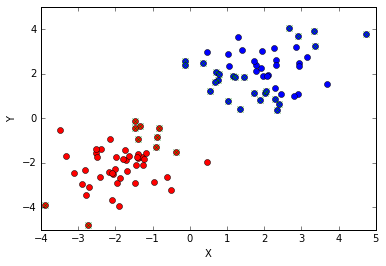

Confusion Matrix
[[50  0]
 [ 0 50]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [225]:
G = poly_kernel(X_lin,0.1)
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'hard')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_soft = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_soft)

     pcost       dcost       gap    pres   dres
 0: -1.1776e+01 -1.9817e+02  1e+03  3e+00  1e-14
 1: -5.7896e+00 -1.0489e+02  2e+02  3e-01  8e-15
 2: -6.0377e-01 -1.4324e+01  2e+01  4e-02  5e-15
 3:  4.7619e-01 -2.4941e+00  4e+00  6e-03  3e-15
 4:  3.9459e-01 -3.3517e-01  1e+00  1e-03  1e-15
 5:  3.1191e-01  1.9048e-01  1e-01  7e-05  1e-15
 6:  2.6887e-01  2.6701e-01  2e-03  8e-07  1e-15
 7:  2.6800e-01  2.6798e-01  2e-05  8e-09  1e-15
 8:  2.6799e-01  2.6799e-01  2e-07  8e-11  1e-15
Optimal solution found.


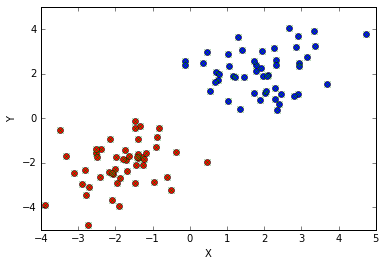

Confusion Matrix
[[50  0]
 [ 0 50]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [226]:
G = poly_kernel(X_lin,0.1)
W_lin,W0_lin,support_vector = training(X_lin,Y_lin,G,typ = 'soft')
plotdata(support_vector,X_lin,Y_lin)
predict_lin_soft = prediction(W_lin,W0_lin,X_lin)
evaluation([-1.0,1.0],Y_lin,predict_lin_soft)

## Hard margin linearly  non separable

In [239]:
ww = np.array([[0.01,0.05 ]])
ww0 = np.array([[0]])
X_nonlin,Y_nonlin = lin_nonsep_data(100,2,0,ww,ww0)

     pcost       dcost       gap    pres   dres
 0: -3.0476e+01 -6.1184e+01  4e+02  2e+01  2e+00
 1: -7.0352e+01 -7.0047e+01  2e+02  1e+01  9e-01
 2: -1.6450e+02 -1.5354e+02  2e+02  9e+00  9e-01
 3: -5.4752e+02 -4.6426e+02  2e+02  9e+00  8e-01
 4: -2.3459e+02 -1.9597e+02  4e+02  6e+00  6e-01
 5: -1.7713e+02 -1.3679e+02  1e+02  2e+00  2e-01
 6: -9.8041e+01 -1.0282e+02  5e+00  1e-13  2e-14
 7: -1.0018e+02 -1.0035e+02  2e-01  2e-14  2e-14
 8: -1.0026e+02 -1.0027e+02  1e-02  2e-13  2e-14
 9: -1.0027e+02 -1.0027e+02  1e-04  5e-14  2e-14
10: -1.0027e+02 -1.0027e+02  1e-06  3e-14  2e-14
Optimal solution found.


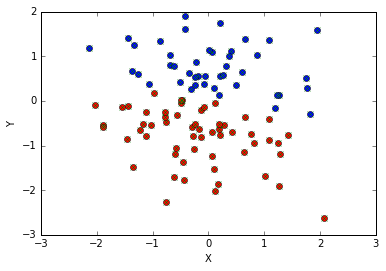

Confusion Matrix
[[57  0]
 [ 5 38]]
Accuracy 0.95
Precision [0.91935483870967738, 1.0]
Recall [1.0, 0.88372093023255816]
F_score [0.95798319327731085, 0.93827160493827166]


In [240]:
G = normal_gram(X_nonlin)
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'hard')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_lin_hard = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_lin_hard)

     pcost       dcost       gap    pres   dres
 0: -3.0131e+01 -2.3890e+02  1e+03  3e+00  2e-15
 1: -1.7448e+01 -1.4977e+02  2e+02  4e-01  2e-15
 2: -6.6623e+00 -2.7764e+01  2e+01  1e-02  8e-15
 3: -1.1357e+01 -1.5457e+01  4e+00  2e-03  1e-15
 4: -1.2669e+01 -1.4025e+01  1e+00  5e-04  9e-16
 5: -1.3108e+01 -1.3498e+01  4e-01  1e-04  1e-15
 6: -1.3242e+01 -1.3355e+01  1e-01  3e-05  9e-16
 7: -1.3286e+01 -1.3302e+01  2e-02  1e-15  1e-15
 8: -1.3294e+01 -1.3295e+01  2e-03  3e-16  1e-15
 9: -1.3294e+01 -1.3294e+01  2e-05  2e-15  1e-15
10: -1.3294e+01 -1.3294e+01  2e-07  3e-16  1e-15
Optimal solution found.


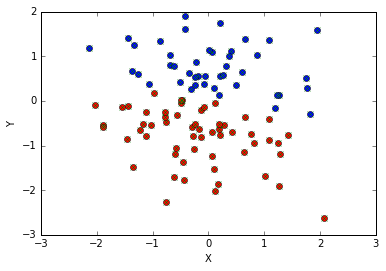

Confusion Matrix
[[57  0]
 [ 0 43]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [241]:
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'soft')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_lin_hard = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_lin_hard)

# Gaussian Kernel

     pcost       dcost       gap    pres   dres
 0: -3.2463e+01 -8.2099e+01  5e+01  5e-15  2e+00
 1: -3.9395e+01 -4.1727e+01  2e+00  1e-15  3e-01
 2: -4.1729e+01 -4.1930e+01  2e-01  5e-15  3e-03
 3: -4.1730e+01 -4.1734e+01  5e-03  4e-15  4e-05
 4: -4.1730e+01 -4.1730e+01  1e-04  2e-15  7e-07
 5: -4.1730e+01 -4.1730e+01  1e-06  2e-15  7e-09
Optimal solution found.


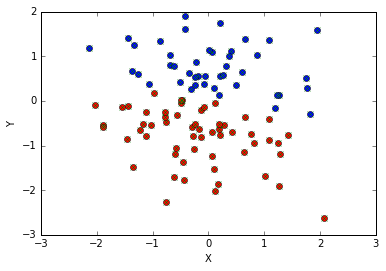

Confusion Matrix
[[57  0]
 [ 5 38]]
Accuracy 0.95
Precision [0.91935483870967738, 1.0]
Recall [1.0, 0.88372093023255816]
F_score [0.95798319327731085, 0.93827160493827166]


In [243]:
G = kernel_gram_matrix(X_nonlin,0.1)
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'hard')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_nonlin_soft = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -3.8227e+01 -1.6034e+02  1e+02  6e-15  4e-16
 1: -3.9642e+01 -4.7319e+01  8e+00  8e-16  2e-16
 2: -4.1185e+01 -4.1957e+01  8e-01  2e-16  9e-17
 3: -4.1388e+01 -4.1470e+01  8e-02  7e-16  9e-17
 4: -4.1413e+01 -4.1416e+01  3e-03  7e-16  1e-16
 5: -4.1415e+01 -4.1415e+01  1e-04  7e-16  1e-16
 6: -4.1415e+01 -4.1415e+01  1e-06  2e-15  1e-16
Optimal solution found.


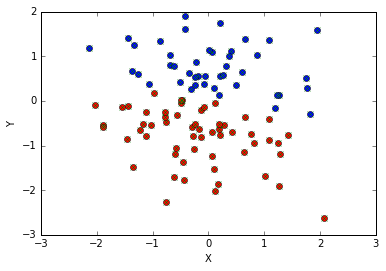

Confusion Matrix
[[57  0]
 [ 6 37]]
Accuracy 0.94
Precision [0.90476190476190477, 1.0]
Recall [1.0, 0.86046511627906974]
F_score [0.95000000000000007, 0.92499999999999993]


In [244]:
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'soft')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_nonlin_soft = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -2.9976e+01 -6.0684e+01  4e+02  2e+01  2e+00
 1: -6.9852e+01 -6.9547e+01  2e+02  1e+01  9e-01
 2: -1.6400e+02 -1.5304e+02  2e+02  9e+00  9e-01
 3: -5.4702e+02 -4.6376e+02  2e+02  9e+00  8e-01
 4: -2.3409e+02 -1.9547e+02  4e+02  6e+00  6e-01
 5: -1.7663e+02 -1.3629e+02  1e+02  2e+00  2e-01
 6: -9.7541e+01 -1.0232e+02  5e+00  1e-13  4e-14
 7: -9.9682e+01 -9.9854e+01  2e-01  4e-14  3e-14
 8: -9.9760e+01 -9.9770e+01  1e-02  8e-14  3e-14
 9: -9.9768e+01 -9.9768e+01  1e-04  9e-14  4e-14
10: -9.9768e+01 -9.9768e+01  1e-06  4e-14  3e-14
Optimal solution found.


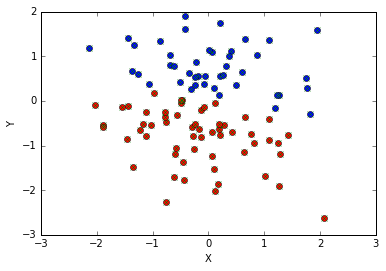

Confusion Matrix
[[57  0]
 [ 5 38]]
Accuracy 0.95
Precision [0.91935483870967738, 1.0]
Recall [1.0, 0.88372093023255816]
F_score [0.95798319327731085, 0.93827160493827166]


In [245]:
G = poly_kernel(X_nonlin,0.1)
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'hard')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_nonlin_soft = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -2.9631e+01 -2.3840e+02  1e+03  3e+00  3e-15
 1: -1.6948e+01 -1.4927e+02  2e+02  4e-01  2e-15
 2: -6.1623e+00 -2.7264e+01  2e+01  1e-02  9e-15
 3: -1.0857e+01 -1.4957e+01  4e+00  2e-03  2e-15
 4: -1.2169e+01 -1.3525e+01  1e+00  5e-04  1e-15
 5: -1.2608e+01 -1.2998e+01  4e-01  1e-04  1e-15
 6: -1.2742e+01 -1.2855e+01  1e-01  3e-05  1e-15
 7: -1.2786e+01 -1.2802e+01  2e-02  2e-16  1e-15
 8: -1.2794e+01 -1.2795e+01  2e-03  2e-16  1e-15
 9: -1.2794e+01 -1.2794e+01  2e-05  2e-15  1e-15
10: -1.2794e+01 -1.2794e+01  2e-07  1e-15  2e-15
Optimal solution found.


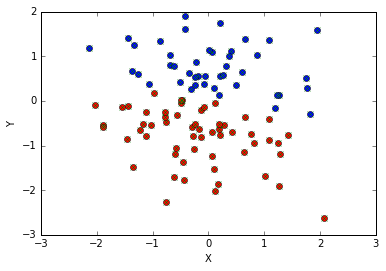

Confusion Matrix
[[57  0]
 [ 0 43]]
Accuracy 1.0
Precision [1.0, 1.0]
Recall [1.0, 1.0]
F_score [1.0, 1.0]


In [246]:
W_nonlin,W0_nonlin,support_vector = training(X_nonlin,Y_nonlin,G,typ = 'soft')
plotdata(support_vector,X_nonlin,Y_nonlin)
predict_nonlin_soft = prediction(W_nonlin,W0_nonlin,X_nonlin)
evaluation([-1.0,1.0],Y_nonlin,predict_nonlin_soft)

In [250]:
G = kernel_gram_matrix(X,.1)
W,W0,svector = training(X,Y,G,typ = 'hard')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -1.7828e+02 -4.3650e+02  3e+02  1e-13  2e+00
 1: -2.1895e+02 -2.3189e+02  1e+01  2e-14  3e-01
 2: -2.3134e+02 -2.3229e+02  9e-01  3e-13  5e-03
 3: -2.3134e+02 -2.3135e+02  1e-02  2e-13  5e-05
 4: -2.3134e+02 -2.3134e+02  1e-04  3e-13  5e-07
 5: -2.3134e+02 -2.3134e+02  1e-06  2e-13  5e-09
Optimal solution found.
Confusion Matrix
[[458   0]
 [ 90 151]]
Accuracy 0.871244635193
Precision [0.83576642335766427, 1.0]
Recall [1.0, 0.62655601659751037]
F_score [0.91053677932405563, 0.77040816326530615]


In [252]:
W,W0,svector = training(X,Y,G,typ = 'soft')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -2.0575e+02 -1.1231e+03  9e+02  1e-13  3e-16
 1: -2.1708e+02 -2.8215e+02  7e+01  8e-14  2e-16
 2: -2.2902e+02 -2.3461e+02  6e+00  2e-13  1e-16
 3: -2.3095e+02 -2.3158e+02  6e-01  3e-13  9e-17
 4: -2.3122e+02 -2.3127e+02  5e-02  3e-13  8e-17
 5: -2.3125e+02 -2.3125e+02  7e-04  6e-14  9e-17
 6: -2.3125e+02 -2.3125e+02  7e-06  1e-13  9e-17
Optimal solution found.
Confusion Matrix
[[458   0]
 [ 90 151]]
Accuracy 0.871244635193
Precision [0.83576642335766427, 1.0]
Recall [1.0, 0.62655601659751037]
F_score [0.91053677932405563, 0.77040816326530615]


In [151]:
G = kernel_gram_matrix(X,0.1)
W,W0 = training(X,Y,G,typ = 'hard')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -1.7828e+02 -4.3650e+02  3e+02  1e-13  2e+00
 1: -2.1895e+02 -2.3189e+02  1e+01  2e-14  3e-01
 2: -2.3134e+02 -2.3229e+02  9e-01  3e-13  5e-03
 3: -2.3134e+02 -2.3135e+02  1e-02  2e-13  5e-05
 4: -2.3134e+02 -2.3134e+02  1e-04  3e-13  5e-07
 5: -2.3134e+02 -2.3134e+02  1e-06  2e-13  5e-09
Optimal solution found.
Confusion Matrix
[[458   0]
 [ 90 151]]
Accuracy 0.871244635193
Precision [0.83576642335766427, 1.0]
Recall [1.0, 0.62655601659751037]
F_score [0.91053677932405563, 0.77040816326530615]


In [152]:
G = kernel_gram_matrix(X,0.1)
W,W0 = training(X,Y,G,typ = 'soft')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -2.0575e+02 -1.1231e+03  9e+02  1e-13  3e-16
 1: -2.1708e+02 -2.8215e+02  7e+01  8e-14  2e-16
 2: -2.2902e+02 -2.3461e+02  6e+00  2e-13  1e-16
 3: -2.3095e+02 -2.3158e+02  6e-01  3e-13  9e-17
 4: -2.3122e+02 -2.3127e+02  5e-02  3e-13  8e-17
 5: -2.3125e+02 -2.3125e+02  7e-04  6e-14  9e-17
 6: -2.3125e+02 -2.3125e+02  7e-06  1e-13  9e-17
Optimal solution found.
Confusion Matrix
[[458   0]
 [ 90 151]]
Accuracy 0.871244635193
Precision [0.83576642335766427, 1.0]
Recall [1.0, 0.62655601659751037]
F_score [0.91053677932405563, 0.77040816326530615]


In [253]:
G = poly_kernel(X,0.1)
W,W0,svector = training(X,Y,G,typ = 'soft')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -9.9795e+01 -1.3873e+03  7e+03  3e+00  2e-12
 1: -6.3233e+01 -7.7120e+02  1e+03  4e-01  2e-12
 2: -5.0165e+01 -3.7406e+02  6e+02  1e-01  9e-13
 3: -4.2762e+01 -2.0143e+02  3e+02  6e-02  6e-13
 4: -3.8834e+01 -1.1281e+02  1e+02  2e-02  5e-13
 5: -3.8328e+01 -6.6936e+01  4e+01  7e-03  5e-13
 6: -3.8514e+01 -5.6390e+01  2e+01  3e-03  5e-13
 7: -3.9833e+01 -5.1955e+01  1e+01  1e-03  5e-13
 8: -3.9668e+01 -5.0513e+01  1e+01  6e-04  5e-13
 9: -4.0394e+01 -4.8357e+01  8e+00  4e-04  5e-13
10: -4.0759e+01 -4.6838e+01  6e+00  2e-04  5e-13
11: -4.1754e+01 -4.4692e+01  3e+00  6e-05  6e-13
12: -4.1998e+01 -4.4012e+01  2e+00  2e-05  6e-13
13: -4.2567e+01 -4.3179e+01  6e-01  4e-06  6e-13
14: -4.2793e+01 -4.2871e+01  8e-02  3e-07  6e-13
15: -4.2828e+01 -4.2829e+01  1e-03  4e-09  7e-13
16: -4.2828e+01 -4.2828e+01  1e-05  4e-11  7e-13
Optimal solution found.
Confusion Matrix
[[452   6]
 [ 29 212]]
Accuracy 0.949928469242
Precision [0.93970893970893976,

In [254]:
G = poly_kernel(X,1)
W,W0,svector = training(X,Y,G,typ = 'soft')
predict = prediction(W,W0,X)
evaluation([-1.0,1.0],Y,predict)

     pcost       dcost       gap    pres   dres
 0: -9.9795e+01 -1.3873e+03  7e+03  3e+00  2e-12
 1: -6.3233e+01 -7.7120e+02  1e+03  4e-01  2e-12
 2: -5.0165e+01 -3.7406e+02  6e+02  1e-01  9e-13
 3: -4.2762e+01 -2.0143e+02  3e+02  6e-02  6e-13
 4: -3.8834e+01 -1.1281e+02  1e+02  2e-02  5e-13
 5: -3.8328e+01 -6.6936e+01  4e+01  7e-03  5e-13
 6: -3.8514e+01 -5.6390e+01  2e+01  3e-03  5e-13
 7: -3.9833e+01 -5.1955e+01  1e+01  1e-03  5e-13
 8: -3.9668e+01 -5.0513e+01  1e+01  6e-04  5e-13
 9: -4.0394e+01 -4.8357e+01  8e+00  4e-04  5e-13
10: -4.0759e+01 -4.6838e+01  6e+00  2e-04  5e-13
11: -4.1754e+01 -4.4692e+01  3e+00  6e-05  6e-13
12: -4.1998e+01 -4.4012e+01  2e+00  2e-05  6e-13
13: -4.2567e+01 -4.3179e+01  6e-01  4e-06  6e-13
14: -4.2793e+01 -4.2871e+01  8e-02  3e-07  6e-13
15: -4.2828e+01 -4.2829e+01  1e-03  4e-09  7e-13
16: -4.2828e+01 -4.2828e+01  1e-05  4e-11  7e-13
Optimal solution found.
Confusion Matrix
[[452   6]
 [ 29 212]]
Accuracy 0.949928469242
Precision [0.93970893970893976,

In [321]:
def lin_nonsep_data1(s,f,d,w,w0):
    n = s
    xx = np.random.rand(n,f)
    yy = classify_dataset(w,w0,xx)
    return xx,np.array(yy)

In [326]:
ww = np.array([[0.5,-0.5]])
ww0 = np.array([[0.1]])
X1,Y1 = lin_nonsep_data1(200,2,0,ww,ww0)

In [327]:
c = Counter()
find_alpha1(Y1)

([1.0, -1.0], {-1.0: 70, 1.0: 130}, {-1.0: 0.35, 1.0: 0.65})

     pcost       dcost       gap    pres   dres
 0: -7.2060e+01 -1.5592e+02  7e+02  3e+01  2e+00
 1: -1.9010e+02 -2.4234e+02  4e+02  1e+01  1e+00
 2: -3.3639e+02 -3.9245e+02  4e+02  1e+01  1e+00
 3: -6.5065e+02 -7.1671e+02  4e+02  1e+01  1e+00
 4: -3.8511e+03 -3.9557e+03  5e+02  1e+01  1e+00
 5: -1.3118e+04 -1.3407e+04  1e+03  1e+01  1e+00
 6: -1.2514e+04 -1.3720e+04  3e+03  1e+01  1e+00
 7: -2.1626e+04 -2.5392e+04  7e+03  1e+01  9e-01
 8: -3.0492e+04 -3.8693e+04  1e+04  6e+00  4e-01
 9: -3.1372e+04 -3.2232e+04  1e+03  4e-01  3e-02
10: -3.1312e+04 -3.1321e+04  1e+01  4e-03  3e-04
11: -3.1312e+04 -3.1312e+04  1e-01  4e-05  3e-06
12: -3.1312e+04 -3.1312e+04  1e-03  4e-07  3e-08
13: -3.1312e+04 -3.1312e+04  1e-05  4e-09  3e-10
Optimal solution found.


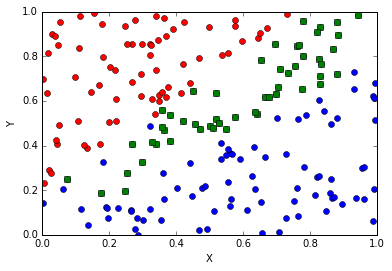

Confusion Matrix
[[ 70   0]
 [112  18]]
Accuracy 0.44
Precision [0.38461538461538464, 1.0]
Recall [1.0, 0.13846153846153847]
F_score [0.55555555555555558, 0.24324324324324326]


In [331]:
G = poly_kernel(X1,0.1)
W1,W10,support_vector1 = training(X1,Y1,G,typ = 'hard')
plotdata1(support_vector1,X1,Y1)
predict_nonlin_soft = prediction(W1,W10,X1)
evaluation([-1.0,1.0],Y1,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -6.9934e+01 -4.6904e+02  2e+03  3e+00  5e-15
 1: -4.1289e+01 -3.0244e+02  4e+02  2e-01  3e-15
 2: -4.0791e+01 -7.6975e+01  4e+01  2e-02  4e-15
 3: -5.3153e+01 -6.2592e+01  1e+01  4e-03  3e-15
 4: -5.5624e+01 -6.0328e+01  5e+00  2e-03  3e-15
 5: -5.6959e+01 -5.9011e+01  2e+00  6e-04  4e-15
 6: -5.7840e+01 -5.8119e+01  3e-01  6e-05  4e-15
 7: -5.7948e+01 -5.8007e+01  6e-02  1e-05  4e-15
 8: -5.7975e+01 -5.7978e+01  2e-03  3e-07  4e-15
 9: -5.7977e+01 -5.7977e+01  2e-05  3e-09  4e-15
Optimal solution found.


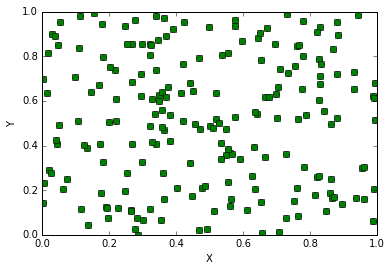

Confusion Matrix
[[ 70   0]
 [ 17 113]]
Accuracy 0.915
Precision [0.8045977011494253, 1.0]
Recall [1.0, 0.86923076923076925]
F_score [0.89171974522292985, 0.93004115226337447]


In [332]:
W1,W10,support_vector1 = training(X1,Y1,G,typ = 'soft')
plotdata1(support_vector1,X1,Y1)
predict_nonlin_soft = prediction(W1,W10,X1)
evaluation([-1.0,1.0],Y1,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -2.4526e+01 -8.5207e+01  6e+01  2e-15  2e+00
 1: -2.9560e+01 -5.1773e+01  2e+01  1e-15  8e-01
 2: -4.1511e+01 -6.6780e+01  3e+01  2e-15  6e-01
 3: -4.7924e+01 -5.4775e+01  7e+00  4e-15  1e-01
 4: -4.8908e+01 -4.9908e+01  1e+00  1e-14  1e-02
 5: -4.9116e+01 -4.9350e+01  2e-01  1e-14  2e-03
 6: -4.9186e+01 -4.9223e+01  4e-02  5e-15  7e-16
 7: -4.9201e+01 -4.9205e+01  3e-03  2e-15  7e-16
 8: -4.9203e+01 -4.9203e+01  5e-04  6e-15  1e-15
 9: -4.9203e+01 -4.9203e+01  1e-05  4e-15  7e-16
Optimal solution found.


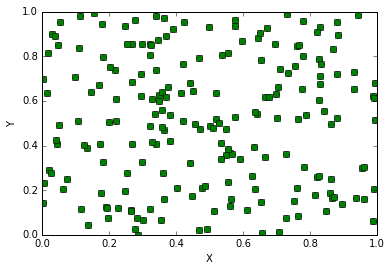

Confusion Matrix
[[70  0]
 [31 99]]
Accuracy 0.845
Precision [0.69306930693069302, 1.0]
Recall [1.0, 0.7615384615384615]
F_score [0.81871345029239762, 0.86462882096069871]


In [333]:
G = kernel_gram_matrix(X1,0.1)
W1,W10,support_vector1 = training(X1,Y1,G,typ = 'hard')
plotdata1(support_vector1,X1,Y1)
predict_nonlin_soft = prediction(W1,W10,X1)
evaluation([-1.0,1.0],Y1,predict_nonlin_soft)

     pcost       dcost       gap    pres   dres
 0: -2.2865e+01 -2.9528e+02  9e+02  1e+00  7e-16
 1: -1.9358e+01 -1.4075e+02  1e+02  3e-15  4e-16
 2: -2.5800e+01 -4.7844e+01  2e+01  3e-15  4e-16
 3: -2.8367e+01 -3.2102e+01  4e+00  2e-15  2e-16
 4: -2.8960e+01 -2.9808e+01  8e-01  2e-15  2e-16
 5: -2.9108e+01 -2.9338e+01  2e-01  4e-16  2e-16
 6: -2.9156e+01 -2.9203e+01  5e-02  8e-16  2e-16
 7: -2.9166e+01 -2.9172e+01  6e-03  4e-15  2e-16
 8: -2.9167e+01 -2.9168e+01  8e-04  6e-15  2e-16
 9: -2.9167e+01 -2.9167e+01  2e-05  2e-16  2e-16
Optimal solution found.


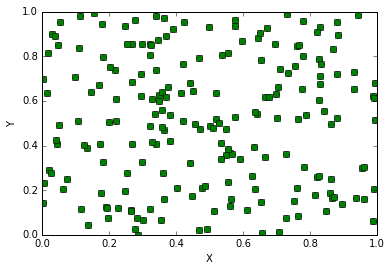

Confusion Matrix
[[ 70   0]
 [ 30 100]]
Accuracy 0.85
Precision [0.69999999999999996, 1.0]
Recall [1.0, 0.76923076923076927]
F_score [0.82352941176470584, 0.86956521739130443]


In [334]:
W1,W10,support_vector1 = training(X1,Y1,G,typ = 'soft')
plotdata1(support_vector1,X1,Y1)
predict_nonlin_soft = prediction(W1,W10,X1)
evaluation([-1.0,1.0],Y1,predict_nonlin_soft)